In [1]:
#dataset https://catalog.data.gov/dataset/consumer-complaint-database

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from pylab import *

import re
import pickle
import requests

from bs4 import BeautifulSoup
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import NearestNeighbors

from sklearn.manifold import TSNE

from nltk import sent_tokenize, word_tokenize,pos_tag
from nltk.corpus import stopwords

%matplotlib inline

plt.style.use('fivethirtyeight')
sns.set(color_codes=True)

import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading the csv
df=pd.read_csv('./datasets/consumer_complaints.csv')

In [3]:
#66k of rows , 18 columns
df.shape

(66806, 18)

In [4]:
df.date_received.head()

0    03/19/2015
1    03/19/2015
2    03/19/2015
3    03/19/2015
4    03/19/2015
Name: date_received, dtype: object

In [5]:
df.date_received.tail()

66801    02/10/2016
66802    02/10/2016
66803    02/11/2016
66804    03/30/2016
66805    02/12/2016
Name: date_received, dtype: object

In [6]:
#sampled 3 rows of data tranposed
df.head(3).T

,0,1,2
date_received,03/19/2015,03/19/2015,03/19/2015
product,Debt collection,Consumer Loan,Mortgage
sub_product,"Other (i.e. phone, health club, etc.)",Vehicle loan,Conventional fixed mortgage
issue,Cont'd attempts collect debt not owed,Managing the loan or lease,"Loan modification,collection,foreclosure"
sub_issue,Debt was paid,NaN,NaN
consumer_complaint_narrative,XXXX has claimed I owe them {$27.00} for XXXX ...,Due to inconsistencies in the amount owed that...,In XX/XX/XXXX my wages that I earned at my job...
company_public_response,NaN,NaN,NaN
company,"Diversified Consultants, Inc.",M&T Bank Corporation,Wells Fargo & Company
state,NY,VA,CA
zipcode,121XX,221XX,946XX


In [7]:
#check % data that is null
total=pd.DataFrame({'is_null':df.isnull().sum().sort_values(ascending=False)})
total['Percentage']= round(total.is_null/len(df),3)
total=total[total.is_null!=0]
total

,is_null,Percentage
tags,55389,0.829
company_public_response,34030,0.509
sub_issue,33874,0.507
sub_product,20455,0.306
zipcode,189,0.003
state,186,0.003


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 18 columns):
date_received                   66806 non-null object
product                         66806 non-null object
sub_product                     46351 non-null object
issue                           66806 non-null object
sub_issue                       32932 non-null object
consumer_complaint_narrative    66806 non-null object
company_public_response         32776 non-null object
company                         66806 non-null object
state                           66620 non-null object
zipcode                         66617 non-null object
tags                            11417 non-null object
consumer_consent_provided       66806 non-null object
submitted_via                   66806 non-null object
date_sent_to_company            66806 non-null object
company_response_to_consumer    66806 non-null object
timely_response                 66806 non-null object
consumer_disputed?         

In [9]:
#this will be the target variable for classification
#we need to encode these 'product'(category)
df['product'].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64

In [10]:
#will not be using this as this will contribute data leak
#reason is because sub_product is a branch off product
df.sub_product.value_counts()

Conventional fixed mortgage               6639
Other (i.e. phone, health club, etc.)     5253
Checking account                          3819
I do not know                             3795
Credit card                               3517
FHA mortgage                              2776
Medical                                   2725
Non-federal student loan                  2456
Conventional adjustable mortgage (ARM)    2378
Vehicle loan                              2065
Payday loan                               1658
Other mortgage                            1410
Other bank product/service                1353
Installment loan                          1182
Home equity loan or line of credit         948
VA mortgage                                639
General purpose card                       439
Auto                                       399
Domestic (US) money transfer               379
Mortgage                                   366
Savings account                            363
Vehicle lease

In [11]:
#will not be using this column as this is a action/followup after it is classified
df.issue.value_counts().head(10)

Incorrect information on credit report      8352
Cont'd attempts collect debt not owed       7520
Loan servicing, payments, escrow account    6554
Loan modification,collection,foreclosure    5163
Disclosure verification of debt             2912
Communication tactics                       2759
Account opening, closing, or management     2228
Credit reporting company's investigation    1990
Managing the loan or lease                  1650
False statements or representation          1647
Name: issue, dtype: int64

In [12]:
#half of the data is not available 
#will not be using this column as this is a action/followup after it is classified
df.sub_issue.unique()

array(['Debt was paid', nan, 'Debt is not mine',
       'Impersonated an attorney or official',
       'Debt resulted from identity theft',
       'Report improperly shared by CRC',
       "Can't decrease my monthly payments", 'Account status',
       'Information is not mine', 'Account terms',
       'Problem getting report or credit score',
       'Contacted me instead of my attorney',
       'Frequent or repeated calls', 'Public record',
       'Attempted to collect wrong amount',
       "Can't get flexible payment options", "Can't contact lender",
       'Billing dispute', 'Keep getting calls about my loan',
       'Trouble with how payments are handled',
       'Threatened arrest/jail if do not pay',
       'Problem getting my free annual report',
       'Having problems with customer service',
       'Reinserted previously deleted info',
       'Problem with statement of dispute',
       'Threatened to take legal action',
       'No notice of investigation status/result',
       

In [13]:
#this will be the primary input for NLP
df.consumer_complaint_narrative.head(20)

0     XXXX has claimed I owe them {$27.00} for XXXX ...
1     Due to inconsistencies in the amount owed that...
2     In XX/XX/XXXX my wages that I earned at my job...
3     I have an open and current mortgage with Chase...
4     XXXX was submitted XX/XX/XXXX. At the time I s...
5     Experian is reporting my OPEN and CURRENT Mort...
6     This complaint is against Wells Fargo Bank for...
7     I spoke to XXXX of green tree representatives ...
8     i opened XXXX Bank of America credit cards 15-...
9     I applied for a loan with XXXX XXXX and had pu...
10    I am very disappointed that the CFPB did not h...
11    Mel S. Harris & assoc. used deceptive collecti...
12    I have a car loan with PNC bank. In XXXX of 20...
13    a incorrect reporting by cavalry portfolio on ...
14    Lawyers at this law firm ( XXXX ) sent me a le...
15    In XX/XX/XXXX I filed a police report regardin...
16    I received services from a healthcare provider...
17    Nationstar Mortgage withheld money from my

In [14]:
df.company_public_response.value_counts(normalize=True)

Company chooses not to provide a public response                                                                           0.589120
Company believes it acted appropriately as authorized by contract or law                                                   0.200421
Company has responded to the consumer and the CFPB and chooses not to provide a public response                            0.113010
Company disputes the facts presented in the complaint                                                                      0.021144
Company believes complaint caused principally by actions of third party outside the control or direction of the company    0.020167
Company believes the complaint is the result of a misunderstanding                                                         0.019313
Company believes complaint is the result of an isolated error                                                              0.014950
Company can't verify or dispute the facts in the complaint                  

In [15]:
#some EDA is definitely required if certain complaints are localized at certain companies
df.company.value_counts().head(20)

Equifax                                   4195
Experian                                  3934
TransUnion Intermediate Holdings, Inc.    3863
Bank of America                           3498
Wells Fargo & Company                     3075
Citibank                                  2789
JPMorgan Chase & Co.                      2586
Ocwen                                     1620
Capital One                               1504
Synchrony Financial                       1375
Nationstar Mortgage                       1372
U.S. Bancorp                              1080
Ditech Financial LLC                      1068
Navient Solutions, Inc.                    997
Encore Capital Group                       865
Amex                                       740
Portfolio Recovery Associates, Inc.        680
PayPal Holdings, Inc.                      637
ERC                                        622
Discover                                   560
Name: company, dtype: int64

In [16]:
state=df.state.values
df.state.unique()

array(['NY', 'VA', 'CA', 'OR', 'MS', 'NJ', 'MD', 'FL', 'LA', 'KY', 'GA',
       'TN', 'NV', 'OH', 'TX', 'AL', 'SC', 'MN', 'AZ', 'WA', 'AK', 'PA',
       'MA', 'ND', 'CO', 'MI', 'NH', 'RI', 'MO', 'ME', 'IL', 'IN', 'HI',
       'NE', 'CT', 'NC', 'IA', 'DE', 'DC', 'WI', 'ID', 'AR', 'AE', 'NM',
       'WV', 'KS', 'PR', 'OK', 'UT', 'SD', 'AP', 'VT', nan, 'MT', 'WY',
       'MP', 'FM', 'VI', 'GU', 'AA', 'AS'], dtype=object)

In [17]:
#we will drop this column as everyone provided consent
df.consumer_consent_provided.unique()
df.drop('consumer_consent_provided',axis=1,inplace=True)

In [18]:
#we will drop this column as everything is submitted via web
df.submitted_via.unique()
df.drop('submitted_via',axis=1,inplace=True)

In [19]:
#impute 'state' that is np.nan based on most occurence of the bank(state)
df.loc[df.state.isnull(),'state']=df.groupby('company')['state'].transform(lambda x : x.value_counts().index[0])

In [20]:
# this column will be drop as it is not useful for EDA or ML
df.complaint_id.head()
df.drop('complaint_id',axis=1)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?
0,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,03/19/2015,Closed with explanation,Yes,No
1,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,03/19/2015,Closed with explanation,Yes,No
2,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,03/19/2015,Closed with explanation,Yes,Yes
3,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I have an open and current mortgage with Chase...,NaN,JPMorgan Chase & Co.,CA,900XX,Older American,03/19/2015,Closed with explanation,Yes,Yes
4,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,03/19/2015,Closed with explanation,Yes,Yes
5,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,Experian is reporting my OPEN and CURRENT Mort...,Company chooses not to provide a public response,Experian,CA,900XX,Older American,03/25/2015,Closed with explanation,Yes,No
6,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,This complaint is against Wells Fargo Bank for...,NaN,Wells Fargo & Company,CA,931XX,NaN,03/19/2015,Closed with explanation,Yes,No
7,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I spoke to XXXX of green tree representatives ...,NaN,Ditech Financial LLC,CA,948XX,NaN,03/19/2015,Closed with non-monetary relief,Yes,No
8,03/19/2015,Credit card,NaN,Other,NaN,i opened XXXX Bank of America credit cards 15-...,Company chooses not to provide a public response,Bank of America,OR,971XX,NaN,03/19/2015,Closed with monetary relief,Yes,Yes
9,03/19/2015,Consumer Loan,Vehicle loan,Taking out the loan or lease,NaN,I applied for a loan with XXXX XXXX and had pu...,NaN,Hyundai Capital America,MS,392XX,NaN,03/19/2015,Closed with explanation,Yes,No


## **EDA**

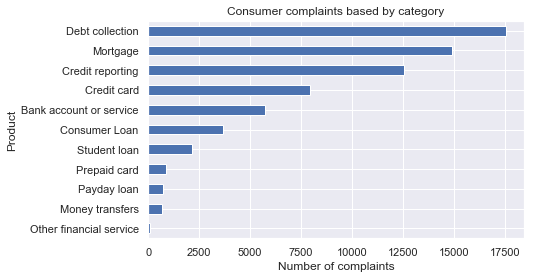

In [22]:
# this is our target variable 
# imbalance class detected and for now we will leave it as it is 
# highest complaints from Debt Collection, Morgage, Credit Reporting

df['product'].value_counts().sort_values().plot(kind='barh');
plt.title('Consumer complaints based by category')
plt.xlabel('Number of complaints')
plt.ylabel('Product');

In [23]:
len(df.state.unique())

60

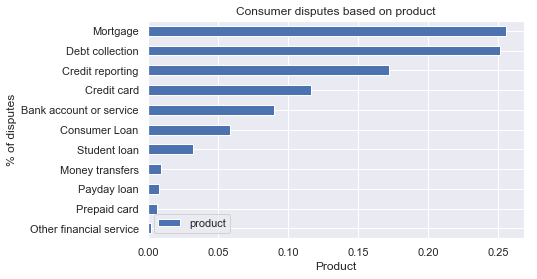

In [24]:
# Top 5 of complaints based on % are Mortgage,Debt collection, Credit reporting, Credit Card, Bank account or service
# From the top 5%, 'Bank account or service' is a low hanging fruit( those that can be solved easily) by re-training 
# the bank personnels.

df[df['consumer_disputed?']=='Yes']['product'].value_counts(normalize=True).sort_values().to_frame().plot(kind='barh');
plt.title('Consumer disputes based on product')
plt.xlabel('Product')
plt.ylabel('% of disputes');

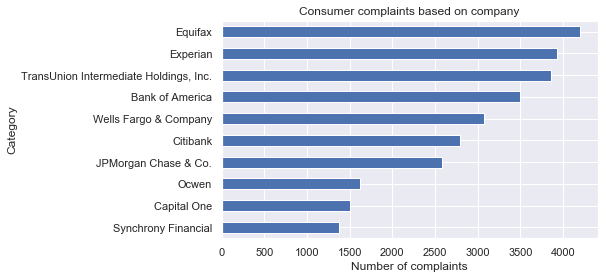

In [25]:
#Equifax has the worst image of all as compared to all financial institutes
#followed by Experian and Transunion. All of 3 of these are credit bureaus
df['company'].value_counts().head(10).sort_values().plot(kind='barh');
plt.title('Consumer complaints based on company')
plt.xlabel('Number of complaints')
plt.ylabel('Category');

In [26]:
df.groupby('company')['product'].value_counts().sort_values(ascending=False).head(30)

company                                 product                
Equifax                                 Credit reporting           4175
Experian                                Credit reporting           3920
TransUnion Intermediate Holdings, Inc.  Credit reporting           3849
Citibank                                Credit card                1655
Wells Fargo & Company                   Mortgage                   1633
Ocwen                                   Mortgage                   1561
Bank of America                         Mortgage                   1391
Nationstar Mortgage                     Mortgage                   1328
Bank of America                         Bank account or service    1122
Ditech Financial LLC                    Mortgage                    997
Capital One                             Credit card                 951
Synchrony Financial                     Credit card                 918
JPMorgan Chase & Co.                    Mortgage                    830


In [27]:
df[df.company=='Equifax']['product'].value_counts()

Credit reporting           4175
Debt collection               7
Consumer Loan                 5
Mortgage                      4
Credit card                   3
Bank account or service       1
Name: product, dtype: int64

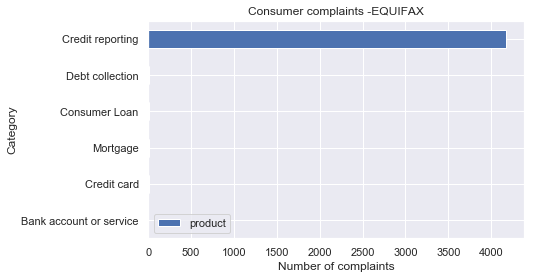

In [52]:
df[df.company=='Equifax']['product'].value_counts().sort_values().to_frame().plot(kind='barh')
plt.title('Consumer complaints -EQUIFAX')
plt.xlabel('Number of complaints')
plt.ylabel('Category');

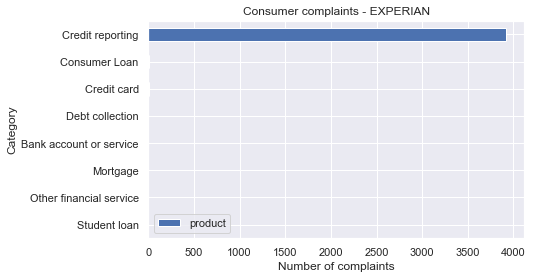

In [53]:
df[df.company=='Experian']['product'].value_counts().sort_values().to_frame().plot(kind='barh')
plt.title('Consumer complaints - EXPERIAN')
plt.xlabel('Number of complaints')
plt.ylabel('Category');

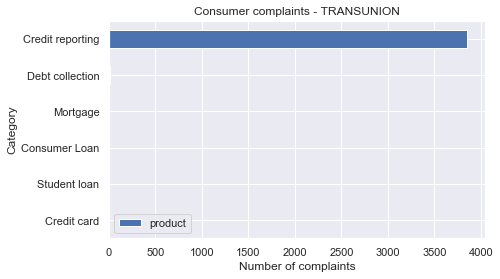

In [54]:
df[df.company=='TransUnion Intermediate Holdings, Inc.']['product'].value_counts().sort_values().to_frame().plot(kind='barh')
plt.title('Consumer complaints - TRANSUNION')
plt.xlabel('Number of complaints')
plt.ylabel('Category');

In [75]:
df.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'date_sent_to_company',
       'company_response_to_consumer', 'timely_response', 'consumer_disputed?',
       'complaint_id'],
      dtype='object')

In [116]:
df['company'].value_counts().head(10)[3:]

Bank of America          3498
Wells Fargo & Company    3075
Citibank                 2789
JPMorgan Chase & Co.     2586
Ocwen                    1620
Capital One              1504
Synchrony Financial      1375
Name: company, dtype: int64

In [120]:
df[df.company=='Bank of America']['product'].value_counts().mean()

318.0

In [123]:
#median for each product in each company for top 10 less 3 credit bureaus
df['company'].value_counts().head(10)[3:].mean()

2349.5714285714284

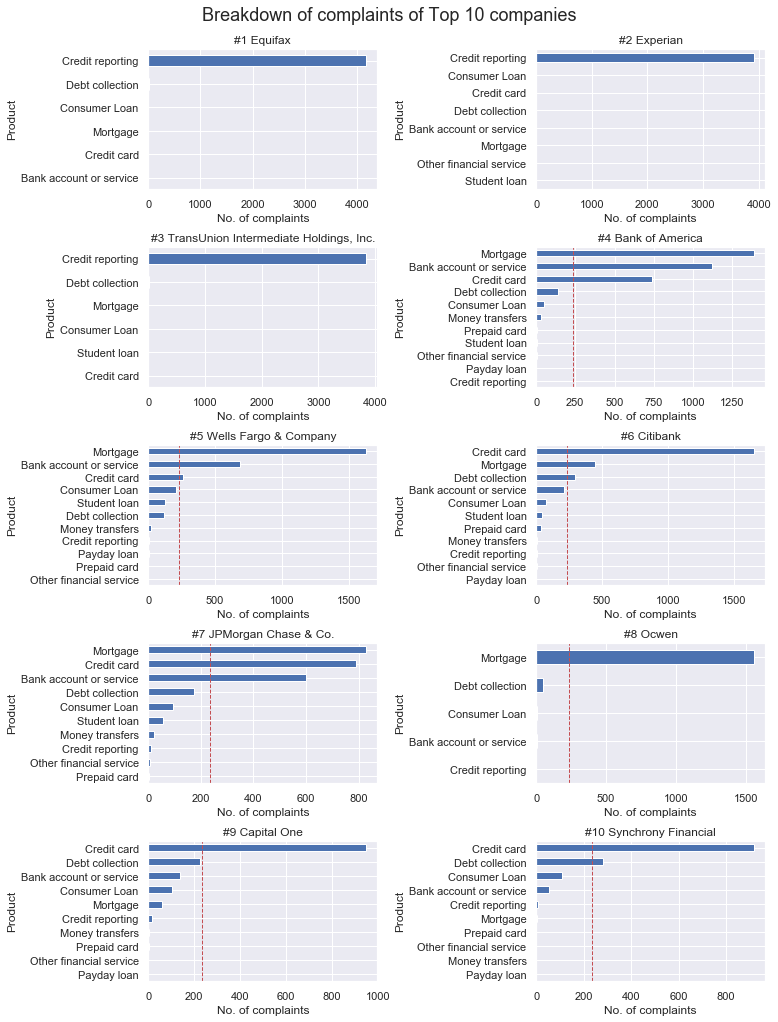

In [124]:
top_10=df['company'].value_counts().head(10).index

plt.suptitle('Breakdown of complaints of Top 10 companies'\
             ,fontsize=18,verticalalignment='top')
for i,co in enumerate(top_10):    
    subplot(5,2,i+1) #subplots always start with 1
    df[df.company==co]['product'].value_counts().sort_values()\
    .plot(kind='barh',figsize=(12, 15))
    plt.title('#{} {}'.format(i+1,co))
    plt.xlabel('No. of complaints')
    plt.ylabel('Product');
    
    if i>2:
        plt.axvline(x=234,linestyle='--',linewidth=1,color='r')
plt.tight_layout(pad=5, w_pad=0.5, h_pad=1.0);

# The top 3 : Equifax, Experian and TransUnion has 'Credit reporting'
# Assumption : Mean complaints for companies between 4 to 10 is around 2349. 
# Hence a cut off of 10%(234) will be used as it is significant enough to demand attention. 
# #1 to #3 is not included as they only have 1 type of complaint
#
# For the rest of the banks ,the complaints are 
#'Mortgage','Bank account or service','Credit Card','Debt collection','Consumer Loan'
# We can consider labelling the top 6 and the rest as others.

In [125]:
#99.6% are credit reporting complaints from 'Equifax','Experian','TransUnion'
credit_bureaus = df[(df['company'] == 'Equifax') | (df['company'] == 'Experian') |\
                    (df['company'] == 'TransUnion Intermediate Holdings, Inc.')]
credit_bureaus['product'].value_counts(normalize=True).mul(100)

Credit reporting           99.599733
Debt collection             0.125083
Consumer Loan               0.083389
Mortgage                    0.075050
Credit card                 0.058372
Student loan                0.025017
Bank account or service     0.025017
Other financial service     0.008339
Name: product, dtype: float64

In [126]:
mask = df['company'].isin(['Equifax'])
#mask = df['company'].isin(['Equifax', 'Experian', 'TransUnion Intermediate Holdings, Inc.'])
non_credit_bureaus = df[~mask]
non_credit_bureaus['product'].value_counts(normalize=True).mul(100)

Debt collection            28.022233
Mortgage                   23.821693
Credit reporting           13.337912
Credit card                12.659117
Bank account or service     9.119803
Consumer Loan               5.866381
Student loan                3.398764
Prepaid card                1.375158
Payday loan                 1.159541
Money transfers             1.063711
Other financial service     0.175688
Name: product, dtype: float64

In [127]:
mask = df['company'].isin(['Experian'])
#mask = df['company'].isin(['Equifax', 'Experian', 'TransUnion Intermediate Holdings, Inc.'])
non_credit_bureaus = df[~mask]
non_credit_bureaus['product'].value_counts(normalize=True).mul(100)

Debt collection            27.913857
Mortgage                   23.725983
Credit reporting           13.688128
Credit card                12.606566
Bank account or service     9.080354
Consumer Loan               5.845209
Student loan                3.383064
Prepaid card                1.369449
Payday loan                 1.154727
Money transfers             1.059295
Other financial service     0.173368
Name: product, dtype: float64

In [128]:
mask = df['company'].isin(['TransUnion Intermediate Holdings, Inc.'])
#mask = df['company'].isin(['Equifax', 'Experian', 'TransUnion Intermediate Holdings, Inc.'])
non_credit_bureaus = df[~mask]
non_credit_bureaus['product'].value_counts(normalize=True).mul(100)

Debt collection            27.876015
Mortgage                   23.697631
Credit reporting           13.785488
Credit card                12.595523
Bank account or service     9.073289
Consumer Loan               5.840205
Student loan                3.377659
Prepaid card                1.367904
Payday loan                 1.153425
Money transfers             1.058100
Other financial service     0.174761
Name: product, dtype: float64

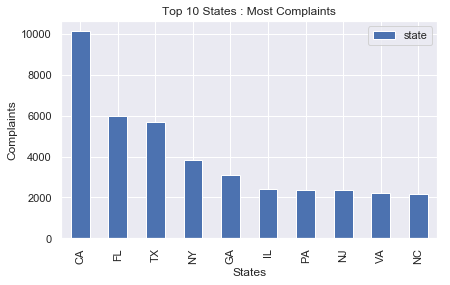

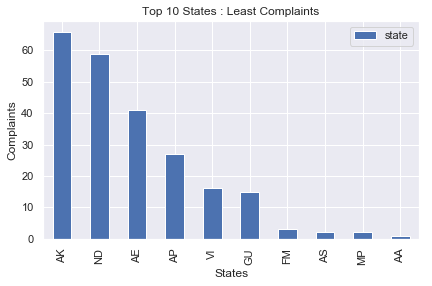

In [129]:
df.state.value_counts().head(10).to_frame().plot(kind='bar');
plt.title('Top 10 States : Most Complaints')
plt.xlabel('States')
plt.ylabel('Complaints');

df.state.value_counts().tail(10).to_frame().plot(kind='bar');
plt.title('Top 10 States : Least Complaints')
plt.xlabel('States')
plt.ylabel('Complaints');

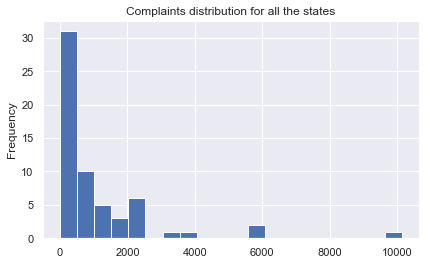

In [130]:
#Heavily skewed to the right
df.state.value_counts().plot(kind='hist',bins=20);
plt.title('Complaints distribution for all the states');

In [131]:
FL=df[df.state=='FL']['product'].value_counts().sort_values().to_frame().T
TX=df[df.state=='TX']['product'].value_counts().sort_values().to_frame().T
chitest=pd.merge(TX,FL,how='outer')
FL=list(chitest.iloc[0,:])
TX=list(chitest.iloc[1,:])
chitest

,Other financial service,Money transfers,Prepaid card,Payday loan,Student loan,Bank account or service,Consumer Loan,Credit card,Mortgage,Credit reporting,Debt collection
0,6,46,64,104,107,378,381,574,936,1229,1879
1,5,45,47,47,136,523,329,624,1460,1183,1567


In [132]:
#Is there any difference in complaints between FL and TX?
#We reject the h0 p-value is < 0.05
#The complaints from FL and TX state are different

chi2, p, dof, expected = stats.chi2_contingency([FL,TX])
chi2,p
prob = 0.95
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

significance=0.050, p=0.000
Dependent (reject H0)


In [133]:
df['company'].value_counts().head(10).index

Index(['Equifax', 'Experian', 'TransUnion Intermediate Holdings, Inc.',
       'Bank of America', 'Wells Fargo & Company', 'Citibank',
       'JPMorgan Chase & Co.', 'Ocwen', 'Capital One', 'Synchrony Financial'],
      dtype='object')

In [134]:
df[df['product']=='Credit reporting']['company'].value_counts().head(5)

Equifax                                                4175
Experian                                               3920
TransUnion Intermediate Holdings, Inc.                 3849
Fidelity National Information Services, Inc. (FNIS)     102
Credit Karma, Inc.                                       68
Name: company, dtype: int64

In [135]:
df.groupby("product")["company"].value_counts()

product                  company                                            
Bank account or service  Bank of America                                        1122
                         Wells Fargo & Company                                   690
                         JPMorgan Chase & Co.                                    601
                         U.S. Bancorp                                            263
                         Citibank                                                214
                         SunTrust Banks, Inc.                                    191
                         PNC Bank N.A.                                           185
                         TD Bank US Holding Company                              182
                         Scottrade Bank                                          154
                         PayPal Holdings, Inc.                                   145
                         USAA Savings                                    

In [136]:
#what is monetary relief
#https://www.upcounsel.com/monetary-relief
df.company_response_to_consumer.value_counts()


Closed with explanation            50928
Closed with non-monetary relief     8607
Closed with monetary relief         4974
Closed                              1766
Untimely response                    531
Name: company_response_to_consumer, dtype: int64

In [137]:
#What product leads to Untimely response
#399(75%) is because of Debt Collection
df[df.company_response_to_consumer=='Untimely response']['product'].value_counts()

Debt collection            399
Mortgage                    51
Payday loan                 31
Consumer Loan               31
Credit reporting             5
Money transfers              5
Credit card                  4
Student loan                 2
Other financial service      2
Bank account or service      1
Name: product, dtype: int64

In [138]:
#around 2% of Debt collection has late responses
(df[df.company_response_to_consumer=='Untimely response']['product'].value_counts()[0]/\
df['product'].value_counts()[0]*100)

2.273245214220602

In [139]:
# 96% are responded in a timely manner
df.timely_response.value_counts(normalize=True)

Yes    0.967548
No     0.032452
Name: timely_response, dtype: float64

In [140]:
# 76% disputed what has been replied by the company 
# which means most customers are not satisfied
df.rename(columns={'consumer_disputed?':'consumer_disputed'}, inplace=True)
df['consumer_disputed'].value_counts(normalize=True).round(2)

No     0.77
Yes    0.23
Name: consumer_disputed, dtype: float64

In [141]:
#we will be using 'product' as our target variable
#and 'consumer_complaint_narrative' as the predictor variable
df=df[['product','consumer_complaint_narrative','state']]


In [142]:
df = df[pd.notnull(df['consumer_complaint_narrative'])]
df.shape

(66806, 3)

In [143]:
#we need to encode these for multi-class classification
df['product'].unique()
df['category_id']=df['product'].factorize()[0]

In [144]:
category_id_df=df[['product','category_id']].drop_duplicates().reset_index(drop=True)
category_id_df

,product,category_id
0,Debt collection,0
1,Consumer Loan,1
2,Mortgage,2
3,Credit card,3
4,Credit reporting,4
5,Student loan,5
6,Bank account or service,6
7,Payday loan,7
8,Money transfers,8
9,Other financial service,9


In [145]:
category_to_id = dict(category_id_df.values)
category_to_id

{'Debt collection': 0,
 'Consumer Loan': 1,
 'Mortgage': 2,
 'Credit card': 3,
 'Credit reporting': 4,
 'Student loan': 5,
 'Bank account or service': 6,
 'Payday loan': 7,
 'Money transfers': 8,
 'Other financial service': 9,
 'Prepaid card': 10}

In [146]:
id_to_category=dict(category_id_df[['category_id','product']].values)
id_to_category

{0: 'Debt collection',
 1: 'Consumer Loan',
 2: 'Mortgage',
 3: 'Credit card',
 4: 'Credit reporting',
 5: 'Student loan',
 6: 'Bank account or service',
 7: 'Payday loan',
 8: 'Money transfers',
 9: 'Other financial service',
 10: 'Prepaid card'}

In [148]:
# Calculate the baseline ( accuracy)
# We get the highest probability of the class to set as baseline
df.category_id.value_counts(normalize=True).max().round(2)

0.26

# Text pre-processing

## Stopwords

In [149]:
# Stopwords from stopwords-json
# https://github.com/6/stopwords-json
r = requests.get('https://raw.githubusercontent.com/6/stopwords-json/master/dist/en.json')
stopwords_json_en= set(r.json())

#stopwords from nltk
stopwords_nltk_en = set(stopwords.words('english'))

#punctuations
from string import punctuation
stopwords_punct = set(punctuation)

stopwords_additional = set('x')

# Combine the stopwords
# set is used as it's faster than list

stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct,stopwords_additional)

print(len(stoplist_combined))
print('nltk\'s default stopwords = {}'.format(len(stopwords_nltk_en)))

631
nltk's default stopwords = 179


In [150]:
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize,pos_tag
from nltk.corpus import stopwords

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
        doc= [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]
        return ' '.join(doc) 

In [151]:
#https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
# leave min_df and max_df unchanged, let TFIDF handle it

#count_vect = CountVectorizer(analyzer=preprocess_text,ngram_range=(1,2), min_df=5)


#count_vect = CountVectorizer(stop_words=stoplist_combined,
#                      tokenizer=word_tokenize,ngram_range=(1,2), min_df=5)

In [ ]:
#X=[ preprocess_text(i) for i in X]

In [ ]:
#save file
#pickle_out = open("./datasets/cleaned_corpus.pickle","wb")
#pickle.dump(cleaned_corpus, pickle_out)
#pickle_out.close()

In [153]:
#load file
pickle_in = open("./datasets/cleaned_corpus.pickle","rb")
X = pickle.load(pickle_in)

In [172]:
X=np.array(X)
pickle_in.close()

In [173]:
def clean(text):
        text = text.lower()
        text = re.sub("W", " ", text)
        text = re.sub("\s+", " ", text)
        text = text.strip(" ")
        text = text.strip("\n")
        text = re.sub("[^\w\s]","",text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('xx', '', text)
        text = re.sub('xxx', '', text)
        text = re.sub('xxxx', '', text)
        text = re.sub('xxxxx', '', text)
        text = re.sub('xxxxxx', '', text)
        text = re.sub('xxxxxxx', '', text)
        text = re.sub('xxxxxxxx', '', text)
        text = re.sub('xxxxxxxxx', '', text)
        text = re.sub('\d+', '', text)
        text = re.sub(' +', ' ',text)
        return text

In [166]:
import string
clean=[]
for sentence in X:
    sentence = re.sub('\w*\d\w*', '', sentence)
    sentence = re.sub('[%s]' % re.escape(string.punctuation), '', sentence)
    sentence = re.sub('xx', '', sentence)
    sentence = re.sub('xxx', '', sentence)
    sentence = re.sub('xxxx', '', sentence)
    sentence = re.sub('xxxxx', '', sentence)
    sentence = re.sub('xxxxxx', '', sentence)
    sentence = re.sub('xxxxxxx', '', sentence)
    sentence = re.sub('xxxxxxxx', '', sentence)
    sentence = re.sub('xxxxxxxxx', '', sentence)
    sentence = re.sub(' +', ' ',sentence)
    clean.append(sentence)
X=clean

## Basic Count for the corpus

In [176]:
#Count Vectorise for EDA

cv = CountVectorizer(ngram_range=(1,2),max_df=.95,min_df=.01)
data_cv = cv.fit_transform(X)
data_dtm = pd.DataFrame(data_cv.toarray(),columns=cv.get_feature_names())

In [177]:
#y 
labels = df.category_id
data_dtm['labels']=labels #pin this

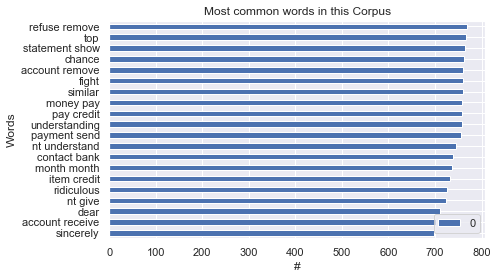

In [178]:
data_dtm.sum(axis=0).sort_values().head(20).to_frame().plot(kind='barh');
plt.title('Most common words in this Corpus')
plt.xlabel('#')
plt.ylabel('Words');

In [179]:
# Lets look through some of the categories common words
names=list(category_id_df['product'])
common_words = []
for i in range(11): #number sync with length of y_train
    word_count = data_dtm[labels==i].sum(axis=0)
    print(word_count)
    print(names[i], "most common words")
    cw = word_count.sort_values(ascending = False).head(10)
    print(cw)
    common_words.extend(cw.index)
    print(common_words)

ability                  205
absolutely               154
accept                   566
access                   268
accord                   465
account                15475
account account          282
account balance          149
account bank              91
account call             154
account charge            82
account close            290
account credit           735
account information      225
account number           691
account open             425
account pay              368
account receive          136
account remove           197
account report           285
account show             160
acct                     299
accurate                 186
acknowledge              322
act                     1466
action                  1588
active                   116
activity                 414
actual                   215
add                      560
                       ...  
victim                   479
victim identity          243
view                      96
violate       

ability                  208
absolutely               169
accept                   368
access                   741
accord                   430
account                15842
account account          532
account balance          143
account bank             103
account call              64
account charge           154
account close            321
account credit           811
account information      191
account number           628
account open             434
account pay              432
account receive           88
account remove           392
account report           627
account show             264
acct                     403
accurate                 654
acknowledge              153
act                     1190
action                   680
active                   138
activity                 336
actual                   184
add                      589
                       ...  
victim                   706
victim identity          433
view                     725
violate       

labels     8610
card       2460
account    1149
call       1041
money      1041
nt          598
day         570
fund        544
receive     518
back        471
dtype: int64
['debt', 'call', 'credit', 'account', 'collection', 'pay', 'report', 'company', 'receive', 'send', 'payment', 'loan', 'call', 'pay', 'credit', 'car', 'labels', 'make', 'account', 'time', 'loan', 'payment', 'labels', 'mortgage', 'call', 'pay', 'home', 'bank', 'time', 'make', 'labels', 'credit', 'card', 'account', 'payment', 'charge', 'call', 'credit card', 'pay', 'bank', 'labels', 'credit', 'report', 'account', 'credit report', 'information', 'dispute', 'remove', 'equifax', 'experian', 'labels', 'loan', 'payment', 'pay', 'call', 'make', 'student', 'time', 'month', 'student loan', 'labels', 'account', 'bank', 'check', 'call', 'fee', 'money', 'charge', 'card', 'deposit', 'labels', 'loan', 'pay', 'call', 'payment', 'account', 'company', 'nt', 'receive', 'make', 'labels', 'money', 'account', 'transfer', 'bank', 'send', '

# Sentiment Analysis

In [183]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [184]:
sid= SentimentIntensityAnalyzer()
data_dtm['sentiment']=df['consumer_complaint_narrative'].apply(lambda x : sid.polarity_scores(x)['compound'])
sentiment_df=category_id_df.copy()
sentiment_df['sentiment']=data_dtm.groupby('labels')['sentiment'].median().values
sentiment_df.drop(columns='category_id',inplace=True)
sentiment_df.set_index('product',inplace=True)

KeyboardInterrupt: 

In [189]:
sentiment=data_dtm['sentiment'] # pin this

In [190]:
#save file
#pickle_out = open("./datasets/data_dtm.pickle","wb")
#pickle.dump(data_dtm, pickle_out)
#pickle_out.close()

In [211]:
#load file
pickle_in = open("./datasets/data_dtm.pickle","rb")
data_dtm = pickle.load(pickle_in)

data_dtm.head()

,ability,ability to,able,able to,about,about it,about my,about the,about this,about xxxx,...,you,you are,you can,you for,you have,you to,you will,your,labels,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.7661
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.8074
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.8837
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0.0000
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2,-0.9018


In [219]:
sentiment=data_dtm[['labels','sentiment']]
sentiment['product']=df['product'].values.copy()

In [221]:
sentiment.head()

,labels,sentiment,product
0,0,-0.7661,Debt collection
1,1,0.8074,Consumer Loan
2,2,0.8837,Mortgage
3,2,0.0000,Mortgage
4,2,-0.9018,Mortgage


In [226]:
sentiment_df=sentiment.groupby('product')['sentiment'].median()

In [227]:
sentiment_df

product
Bank account or service   -0.35950
Consumer Loan              0.00000
Credit card                0.38180
Credit reporting           0.20035
Debt collection           -0.44690
Money transfers           -0.15310
Mortgage                  -0.07250
Other financial service   -0.27320
Payday loan               -0.17790
Prepaid card              -0.35000
Student loan              -0.02580
Name: sentiment, dtype: float64

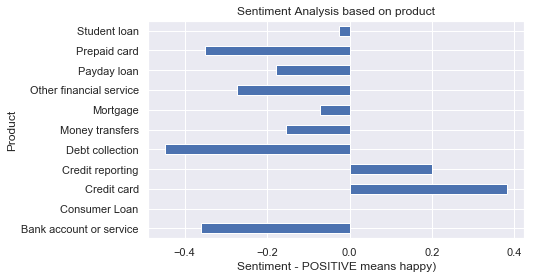

In [228]:
#Besides Credit Reporting and Credit, the rest of the products have very angry customers
#Hence we need to take note of Debt Collection ,Bank account or service and Prepaid card
sentiment_df.plot(kind='barh')
plt.title('Sentiment Analysis based on product')
plt.xlabel('Sentiment - POSITIVE means happy)')
plt.ylabel('Product');

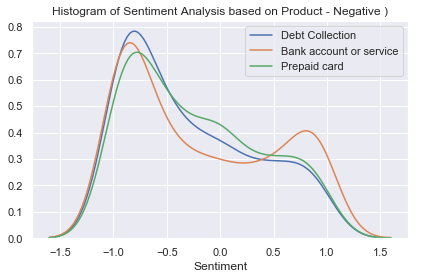

In [229]:
#Skewed to the right

sns.kdeplot(data_dtm[data_dtm.labels==0]['sentiment'].values, bw=.2, label="Debt Collection")
sns.kdeplot(data_dtm[data_dtm.labels==6]['sentiment'].values, bw=.2, label="Bank account or service")
sns.kdeplot(data_dtm[data_dtm.labels==10]['sentiment'].values, bw=.2, label="Prepaid card")
plt.title('Histogram of Sentiment Analysis based on Product - Negative )');
plt.xlabel('Sentiment');

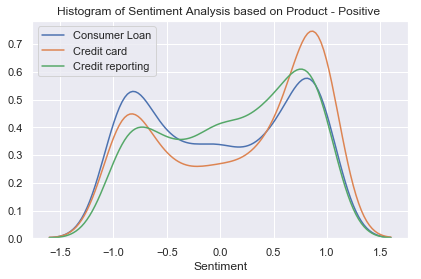

In [230]:
sns.kdeplot(data_dtm[data_dtm.labels==1]['sentiment'].values, bw=.2, label="Consumer Loan")
sns.kdeplot(data_dtm[data_dtm.labels==3]['sentiment'].values, bw=.2, label="Credit card")
sns.kdeplot(data_dtm[data_dtm.labels==4]['sentiment'].values, bw=.2, label="Credit reporting")
plt.title('Histogram of Sentiment Analysis based on Product - Positive ')
plt.xlabel('Sentiment');

## Topic Modelling

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2')
features = tfidf.fit_transform(np.array(X))
labels = df.category_id
features.shape

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation
pyLDAvis.enable_notebook()

### Fit Latent Dirichlet Allocation models

In [ ]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_topics=10, random_state=42,n_jobs=-1)
lda_tf.fit(data_cv) #countvect
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_topics=10, random_state=42,n_jobs=-1)
lda_tfidf.fit(features)# tdidf

### Visualizing the models with pyLDAvis

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, data_cv , cv ) #lda,countvect,tdidf #13 topics

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, data_cv , cv, mds='mmds') #10 topics